# Neural Geometry Across Development

Procrustes analysis of PFC tuning curves across monkeys and developmental ages.
Uses both ODR (8 cue conditions) and ODRd (4 distractor conditions).

**Pipeline:**
1. Load ODR + ODRd data, restrict to shared monkeys
2. Compute tuning curves (conditions × epochs) per task
3. Split neurons into age percentiles per monkey
4. PCA + Procrustes per task, combine distance matrices
5. KNN decoding of monkey ID and age group

In [673]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys, os

sys.path.insert(0, os.path.dirname(os.path.abspath('')))
sys.path.insert(0, '.')

from functions import (
    load_odr_data, load_odrd_data, extract_metadata,
    compute_single_trial_rates, compute_tuning_curves,
    zscore_neurons, pca_reduce, build_representations,
    procrustes_distance_matrix,
    knn_decode_monkey, knn_decode_age, regress_age,
)

DATA_DIR = '../data_raw'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data and extract metadata

In [674]:
# --- Load ODR (8 cue conditions) ---
odr_data, ws_odr = load_odr_data(os.path.join(DATA_DIR, 'odr_data_both_sig_is_best_20240109.mat'))
odr_ids, odr_age, odr_mature, odr_delay = extract_metadata(ws_odr, odr_data.shape[0])

# Filter to 1.5s delay
keep = odr_delay == 1.5
odr_data   = odr_data[keep]
odr_ids    = odr_ids[keep]
odr_age    = odr_age[keep]
odr_mature = odr_mature[keep]

# --- Load ODRd (4 distractor conditions) ---
odrd_data, ws_odrd = load_odrd_data(os.path.join(DATA_DIR, 'odrd_data_sig_on_best_20231018.mat'))
odrd_ids, odrd_age, odrd_mature, _ = extract_metadata(ws_odrd, odrd_data.shape[0])

# Select monkeys (set to None to use all shared monkeys)
USE_MONKEYS = None

# Restrict to monkeys present in both tasks
shared_monkeys = sorted(set(odr_ids) & set(odrd_ids))
if USE_MONKEYS is not None:
    shared_monkeys = [m for m in USE_MONKEYS if m in shared_monkeys]

keep_odr = np.isin(odr_ids, shared_monkeys)
odr_data, odr_ids, odr_age, odr_mature = (
    odr_data[keep_odr], odr_ids[keep_odr], odr_age[keep_odr], odr_mature[keep_odr])

keep_odrd = np.isin(odrd_ids, shared_monkeys)
odrd_data, odrd_ids, odrd_age, odrd_mature = (
    odrd_data[keep_odrd], odrd_ids[keep_odrd], odrd_age[keep_odrd], odrd_mature[keep_odrd])

odr_abs_age  = (odr_age + odr_mature) / 365.0 * 12.0
odrd_abs_age = (odrd_age + odrd_mature) / 365.0 * 12.0

print(f'Shared monkeys: {shared_monkeys}')
print(f'ODR:  {odr_data.shape[0]} neurons x {odr_data.shape[1]} conditions')
print(f'ODRd: {odrd_data.shape[0]} neurons x {odrd_data.shape[1]} conditions')
for mid in shared_monkeys:
    print(f'  {mid}: ODR={np.sum(odr_ids==mid)}, ODRd={np.sum(odrd_ids==mid)}')

Shared monkeys: ['OLI', 'PIC', 'ROS', 'UNI']
ODR:  391 neurons x 8 conditions
ODRd: 1319 neurons x 4 conditions
  OLI: ODR=86, ODRd=292
  PIC: ODR=77, ODRd=264
  ROS: ODR=69, ODRd=236
  UNI: ODR=159, ODRd=527


## 2. Compute tuning curves per task

In [675]:
BIN_MS = 50
bin_edges   = np.arange(-1000, 2500 + BIN_MS, BIN_MS)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

EPOCHS = {
    'cue':      (0,    500),
    'delay':    (500,  2000),
    'response': (2000, 2500),
}

print('Computing ODR firing rates...')
odr_rates = compute_single_trial_rates(odr_data, bin_edges)
print('Computing ODRd firing rates...')
odrd_rates = compute_single_trial_rates(odrd_data, bin_edges)

Computing ODR firing rates...
  neuron 0/391
Computing ODRd firing rates...
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319


In [676]:
odr_tuning, epoch_names = compute_tuning_curves(odr_rates, bin_centers, EPOCHS)
odrd_tuning, _          = compute_tuning_curves(odrd_rates, bin_centers, EPOCHS)

n_odr  = odr_tuning.shape[0]
n_odrd = odrd_tuning.shape[0]

odr_flat  = odr_tuning.reshape(n_odr, -1)    # (n_odr, 8*3=24)
odrd_flat = odrd_tuning.reshape(n_odrd, -1)   # (n_odrd, 4*3=12)

print(f'ODR tuning:  {odr_tuning.shape} → flat {odr_flat.shape}  (8 conds x {len(epoch_names)} epochs)')
print(f'ODRd tuning: {odrd_tuning.shape} → flat {odrd_flat.shape}  (4 conds x {len(epoch_names)} epochs)')
print(f'Epochs: {epoch_names}')

ODR tuning:  (391, 8, 3) → flat (391, 24)  (8 conds x 3 epochs)
ODRd tuning: (1319, 4, 3) → flat (1319, 12)  (4 conds x 3 epochs)
Epochs: ['cue', 'delay', 'response']


## 3. Build representations and decode

Split each monkey's neurons into N_AGE_GROUPS percentiles by age (edges from combined ODR+ODRd ages).
Build PCA representations per task, compute Procrustes distances per task, then average.

In [677]:
# --- Parameters ---
N_AGE_GROUPS = 6
N_PCS = 10
MIN_NEURONS = N_PCS + 1

monkey_names = shared_monkeys

# Compute age-group edges from combined ODR+ODRd ages per monkey
odr_age_group  = np.zeros(len(odr_ids), dtype=int)
odrd_age_group = np.zeros(len(odrd_ids), dtype=int)

print(f'Age groups (N={N_AGE_GROUPS}) per monkey (edges from combined tasks):')
for mid in monkey_names:
    combined_ages = np.concatenate([odr_abs_age[odr_ids == mid],
                                    odrd_abs_age[odrd_ids == mid]])
    edges = np.quantile(combined_ages, np.linspace(0, 1, N_AGE_GROUPS + 1))

    odr_m = odr_ids == mid
    odr_age_group[odr_m] = np.clip(
        np.digitize(odr_abs_age[odr_m], edges[1:-1]), 0, N_AGE_GROUPS - 1)

    odrd_m = odrd_ids == mid
    odrd_age_group[odrd_m] = np.clip(
        np.digitize(odrd_abs_age[odrd_m], edges[1:-1]), 0, N_AGE_GROUPS - 1)

    print(f'\n  {mid} (edges: {", ".join(f"{e:.1f}" for e in edges)} mo):')
    for g in range(N_AGE_GROUPS):
        n_o  = np.sum(odr_age_group[odr_m] == g)
        n_d  = np.sum(odrd_age_group[odrd_m] == g)
        print(f'    G{g}: ODR={n_o}, ODRd={n_d}')

Age groups (N=6) per monkey (edges from combined tasks):

  OLI (edges: 46.5, 53.8, 58.8, 64.1, 64.3, 69.2, 69.4 mo):
    G0: ODR=6, ODRd=55
    G1: ODR=17, ODRd=43
    G2: ODR=15, ODRd=52
    G3: ODR=15, ODRd=32
    G4: ODR=15, ODRd=53
    G5: ODR=18, ODRd=57

  PIC (edges: 46.7, 57.3, 58.2, 58.7, 62.6, 63.2, 63.5 mo):
    G0: ODR=7, ODRd=50
    G1: ODR=17, ODRd=40
    G2: ODR=7, ODRd=47
    G3: ODR=12, ODRd=41
    G4: ODR=16, ODRd=43
    G5: ODR=18, ODRd=43

  ROS (edges: 46.0, 48.2, 52.6, 62.8, 63.5, 67.3, 67.6 mo):
    G0: ODR=7, ODRd=42
    G1: ODR=17, ODRd=27
    G2: ODR=16, ODRd=39
    G3: ODR=10, ODRd=43
    G4: ODR=8, ODRd=44
    G5: ODR=11, ODRd=41

  UNI (edges: 38.7, 44.2, 49.6, 55.8, 60.8, 61.1, 61.5 mo):
    G0: ODR=26, ODRd=87
    G1: ODR=32, ODRd=84
    G2: ODR=17, ODRd=94
    G3: ODR=20, ODRd=96
    G4: ODR=36, ODRd=78
    G5: ODR=28, ODRd=88


In [678]:
# Build PCA representations per task
entries_odr  = build_representations(odr_flat, odr_ids, odr_age_group,
                                     n_pcs=N_PCS, min_neurons=MIN_NEURONS, zscore=True)
entries_odrd = build_representations(odrd_flat, odrd_ids, odrd_age_group,
                                     n_pcs=N_PCS, min_neurons=MIN_NEURONS, zscore=True)

# Keep only (monkey, group) pairs present in BOTH tasks
keys_odr  = {(e['monkey'], e['group']) for e in entries_odr}
keys_odrd = {(e['monkey'], e['group']) for e in entries_odrd}
shared_keys = sorted(keys_odr & keys_odrd)
sk_set = set(shared_keys)

entries_odr_a  = sorted([e for e in entries_odr  if (e['monkey'], e['group']) in sk_set],
                        key=lambda e: (e['group'], e['monkey']))
entries_odrd_a = sorted([e for e in entries_odrd if (e['monkey'], e['group']) in sk_set],
                        key=lambda e: (e['group'], e['monkey']))

# Procrustes per task, then average
dist_odr  = procrustes_distance_matrix(entries_odr_a)
dist_odrd = procrustes_distance_matrix(entries_odrd_a)
dist = (dist_odr + dist_odrd) / 2.0

# Canonical entries list (same monkey/group for both)
entries = entries_odr_a

print(f'ODR entries:  {len(entries_odr)} total, {len(entries_odr_a)} shared')
print(f'ODRd entries: {len(entries_odrd)} total, {len(entries_odrd_a)} shared')
print(f'Combined: {len(entries)} entries')
print()
for mid in monkey_names:
    n = sum(1 for e in entries if e['monkey'] == mid)
    print(f'  {mid}: {n}/{N_AGE_GROUPS} groups')

ODR entries:  18 total, 18 shared
ODRd entries: 24 total, 18 shared
Combined: 18 entries

  OLI: 5/6 groups
  PIC: 4/6 groups
  ROS: 3/6 groups
  UNI: 6/6 groups


In [679]:
# KNN decoding of monkey identity (leave-one-age-out)
acc_mk, y_true_mk, y_pred_mk = knn_decode_monkey(dist, entries, k=3)
print(f'Monkey decoding: {acc_mk:.1%} (chance = {1/len(monkey_names):.1%})')

# Confusion matrix
print(f"\n{'':>5s}", '  '.join(f'{m:>4s}' for m in monkey_names))
for mt in monkey_names:
    row = [np.sum((y_true_mk == mt) & (y_pred_mk == mp)) for mp in monkey_names]
    print(f'{mt:>5s}', '  '.join(f'{c:4d}' for c in row))

Monkey decoding: 38.9% (chance = 25.0%)

       OLI   PIC   ROS   UNI
  OLI    0     1     0     4
  PIC    1     1     0     2
  ROS    2     0     0     1
  UNI    0     0     0     6


In [680]:
# KNN decoding of age group (leave-one-monkey-out)
age_res = knn_decode_age(dist, entries, k=3)
print(f'Age decoding ({N_AGE_GROUPS} groups):')
print(f'  Exact: {age_res["exact_acc"]:.1%} (chance = {1/N_AGE_GROUPS:.1%})')
print(f'  ±1:    {age_res["pm1_acc"]:.1%}')

Age decoding (6 groups):
  Exact: 11.1% (chance = 16.7%)
  ±1:    55.6%


In [681]:
# KNN regression of relative age (leave-one-monkey-out)
age_values = np.array([e['group'] for e in entries], dtype=float)
reg_res = regress_age(dist, entries, age_values, k=3)

print(f'Age regression (KNN, LMOO CV):')
print(f'  r = {reg_res["r"]:.3f}, p = {reg_res["p"]:.4f}')

Age regression (KNN, LMOO CV):
  r = 0.220, p = 0.3793


Mean within-monkey distance (across ages):
  OLI: 5 groups, 10 pairs, mean=0.6778
  PIC: 4 groups, 6 pairs, mean=0.6898
  ROS: 3 groups, 3 pairs, mean=0.6911
  UNI: 6 groups, 15 pairs, mean=0.5864

Cross-monkey distances (n=119):
  Raw:      mean=0.6588  std=0.0488
  Adjusted: mean=0.0033  std=0.0513


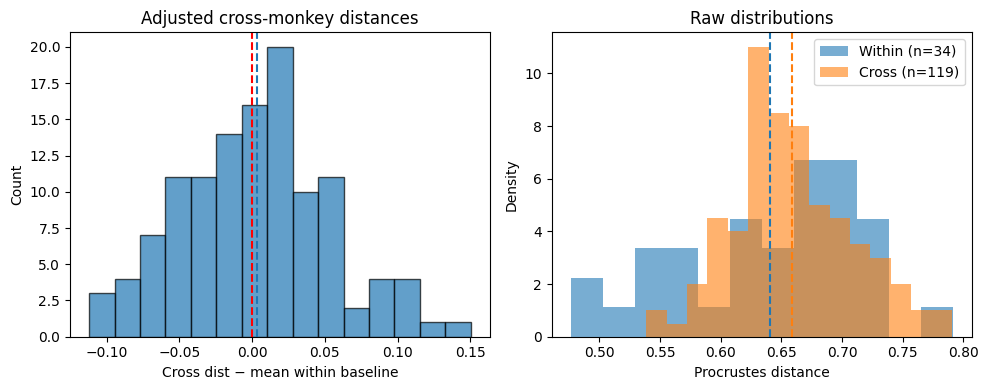

In [682]:
# Within-monkey vs cross-monkey Procrustes distances
monkeys_e = np.array([e['monkey'] for e in entries])
n_entries = len(entries)

# Compute mean within-monkey distance per monkey
mean_within = {}
for mid in monkey_names:
    mk_idx = np.where(monkeys_e == mid)[0]
    if len(mk_idx) < 2:
        mean_within[mid] = np.nan
        continue
    pairs = [dist_odr[i, j] for i in mk_idx for j in mk_idx if j > i]
    mean_within[mid] = np.mean(pairs)

print('Mean within-monkey distance (across ages):')
for mid in monkey_names:
    mk_idx = np.where(monkeys_e == mid)[0]
    n_pairs = len(mk_idx) * (len(mk_idx) - 1) // 2
    print(f'  {mid}: {len(mk_idx)} groups, {n_pairs} pairs, mean={mean_within[mid]:.4f}')

# For each cross-monkey pair, subtract average within-monkey baseline
cross_raw, cross_adj = [], []
for i in range(n_entries):
    for j in range(i + 1, n_entries):
        if monkeys_e[i] == monkeys_e[j]:
            continue
        d_raw = dist_odr[i, j]
        baseline = (mean_within[monkeys_e[i]] + mean_within[monkeys_e[j]]) / 2
        cross_raw.append(d_raw)
        cross_adj.append(d_raw - baseline)

cross_raw = np.array(cross_raw)
cross_adj = np.array(cross_adj)

print(f'\nCross-monkey distances (n={len(cross_raw)}):')
print(f'  Raw:      mean={cross_raw.mean():.4f}  std={cross_raw.std():.4f}')
print(f'  Adjusted: mean={cross_adj.mean():.4f}  std={cross_adj.std():.4f}')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(cross_adj, bins=15, alpha=0.7, edgecolor='k')
axes[0].axvline(0, color='r', ls='--', lw=1.5)
axes[0].axvline(cross_adj.mean(), color='C0', ls='--', lw=1.5)
axes[0].set_xlabel('Cross dist − mean within baseline')
axes[0].set_ylabel('Count')
axes[0].set_title('Adjusted cross-monkey distances')

# Raw within vs cross for reference
within_all = []
for i in range(n_entries):
    for j in range(i + 1, n_entries):
        if monkeys_e[i] == monkeys_e[j]:
            within_all.append(dist_odr[i, j])
within_all = np.array(within_all)

axes[1].hist(within_all, bins=12, alpha=0.6, label=f'Within (n={len(within_all)})', density=True)
axes[1].hist(cross_raw, bins=15, alpha=0.6, label=f'Cross (n={len(cross_raw)})', density=True)
axes[1].axvline(within_all.mean(), color='C0', ls='--', lw=1.5)
axes[1].axvline(cross_raw.mean(), color='C1', ls='--', lw=1.5)
axes[1].set_xlabel('Procrustes distance')
axes[1].set_ylabel('Density')
axes[1].set_title('Raw distributions')
axes[1].legend()
plt.tight_layout()
plt.show()

In [683]:
import scipy.stats as sts
# One-sample t-test: are adjusted cross-monkey distances > 0?
t_stat, p_val = sts.ttest_1samp(cross_adj, 0)
print(f'One-sample t-test on adjusted cross-monkey distances (H0: mean=0):')
print(f'  mean = {cross_adj.mean():.4f}, t = {t_stat:.3f}, p = {p_val:.4f}')

One-sample t-test on adjusted cross-monkey distances (H0: mean=0):
  mean = 0.0033, t = 0.707, p = 0.4811


## 4. Sweep over number of PCs and age groups

In [684]:
print(f'{"PCs":>4s}  {"Groups":>6s}  {"Entries":>7s}  {"Monkey":>8s}  {"Age exact":>10s}  {"Age ±1":>8s}  {"Age regr r":>11s}')
print('-' * 65)

for n_groups in [2, 3, 4, 5]:
    # Assign age groups using combined edges
    ag_odr  = np.zeros(len(odr_ids), dtype=int)
    ag_odrd = np.zeros(len(odrd_ids), dtype=int)
    for mid in monkey_names:
        combined = np.concatenate([odr_abs_age[odr_ids == mid],
                                   odrd_abs_age[odrd_ids == mid]])
        edges = np.quantile(combined, np.linspace(0, 1, n_groups + 1))
        odr_m  = odr_ids == mid
        odrd_m = odrd_ids == mid
        ag_odr[odr_m]   = np.clip(np.digitize(odr_abs_age[odr_m], edges[1:-1]), 0, n_groups - 1)
        ag_odrd[odrd_m] = np.clip(np.digitize(odrd_abs_age[odrd_m], edges[1:-1]), 0, n_groups - 1)

    for n_pcs in [3, 5, 8, 10, 15]:
        min_n = n_pcs + 1
        ent_odr  = build_representations(odr_flat, odr_ids, ag_odr,
                                         n_pcs=n_pcs, min_neurons=min_n, zscore=False)
        ent_odrd = build_representations(odrd_flat, odrd_ids, ag_odrd,
                                         n_pcs=n_pcs, min_neurons=min_n, zscore=False)

        keys_o = {(e['monkey'], e['group']) for e in ent_odr}
        keys_d = {(e['monkey'], e['group']) for e in ent_odrd}
        sk = sorted(keys_o & keys_d)
        sk_s = set(sk)

        eo = sorted([e for e in ent_odr  if (e['monkey'], e['group']) in sk_s],
                    key=lambda e: (e['group'], e['monkey']))
        ed = sorted([e for e in ent_odrd if (e['monkey'], e['group']) in sk_s],
                    key=lambda e: (e['group'], e['monkey']))

        if len(eo) < 3:
            continue

        d = (procrustes_distance_matrix(eo) + procrustes_distance_matrix(ed)) / 2.0

        mk_acc, _, _ = knn_decode_monkey(d, eo, k=3)
        age_r = knn_decode_age(d, eo, k=3)
        age_vals = np.array([e['group'] for e in eo], dtype=float)
        reg = regress_age(d, eo, age_vals, k=3)

        print(f'{n_pcs:4d}  {n_groups:6d}  {len(eo):7d}  {mk_acc:8.1%}  {age_r["exact_acc"]:10.1%}  '
              f'{age_r["pm1_acc"]:8.1%}  {reg["r"]:11.3f}')
    print()

 PCs  Groups  Entries    Monkey   Age exact    Age ±1   Age regr r
-----------------------------------------------------------------
   3       2        8     62.5%       50.0%    100.0%       -0.000
   5       2        8     50.0%       37.5%    100.0%       -0.378
   8       2        8     50.0%       37.5%    100.0%       -0.626
  10       2        8     50.0%       37.5%    100.0%       -0.626
  15       2        8     50.0%       37.5%    100.0%       -0.626

   3       3       12     50.0%       25.0%     75.0%       -0.433
   5       3       12     50.0%       16.7%     75.0%       -0.363
   8       3       12     50.0%       25.0%     75.0%       -0.505
  10       3       12     58.3%       25.0%     75.0%       -0.725
  15       3       12     50.0%       16.7%     75.0%       -0.642

   3       4       16     56.2%       18.8%     62.5%       -0.135
   5       4       16     56.2%       18.8%     56.2%       -0.510
   8       4       16     62.5%       25.0%     62.5%       -

## 5. Plots

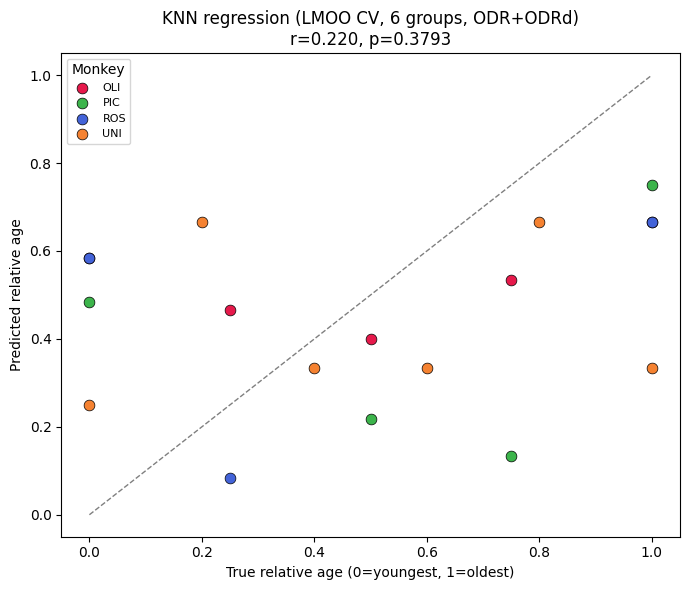

In [685]:
COLORS = {m: c for m, c in zip(monkey_names,
          ['#e6194b','#3cb44b','#4363d8','#f58231'])}

# --- Age regression scatter ---
fig, ax = plt.subplots(figsize=(7, 6))
for mid in monkey_names:
    mask = reg_res['monkey_ids'] == mid
    ax.scatter(reg_res['y_true'][mask], reg_res['y_pred'][mask],
               c=COLORS[mid], s=60, edgecolors='k', linewidths=0.5, label=mid)
ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
ax.set_xlabel('True relative age (0=youngest, 1=oldest)')
ax.set_ylabel('Predicted relative age')
ax.set_title(f'KNN regression (LMOO CV, {N_AGE_GROUPS} groups, ODR+ODRd)\nr={reg_res["r"]:.3f}, p={reg_res["p"]:.4f}')
ax.legend(title='Monkey', fontsize=8)
plt.tight_layout()
plt.show()

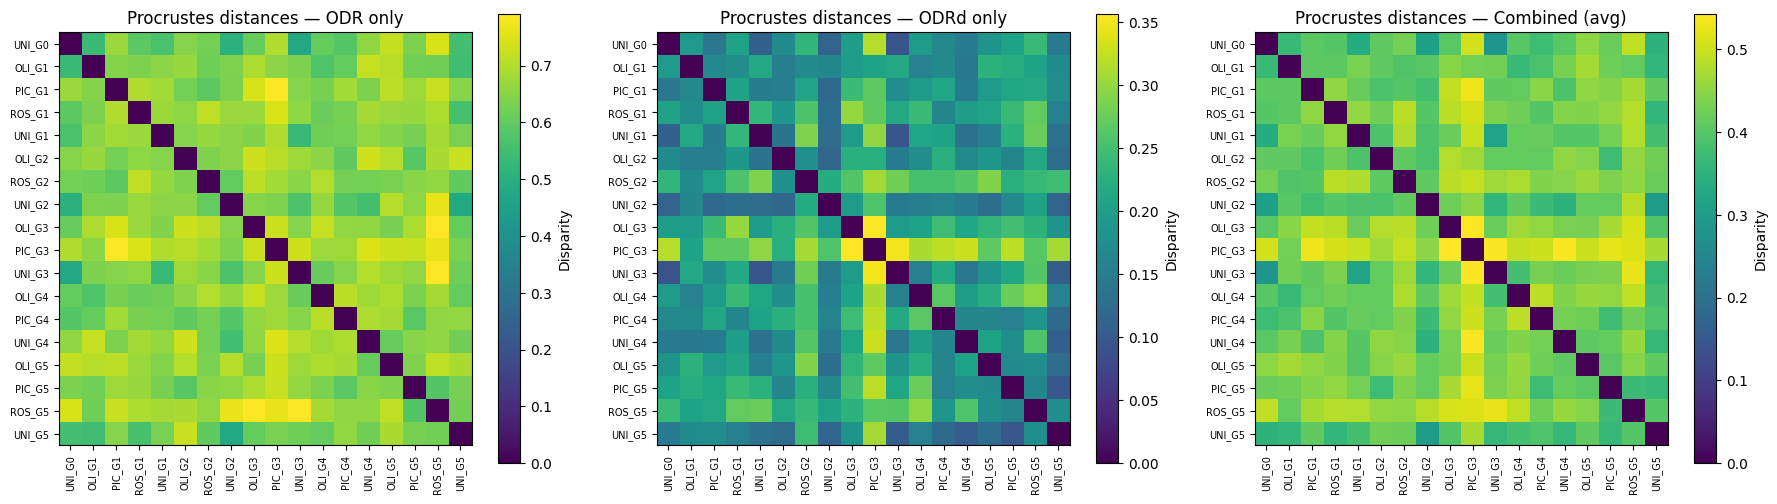

In [686]:
# --- Distance matrix heatmap ---
labels = [f"{e['monkey']}_G{e['group']}" for e in entries]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, d, title in zip(axes, [dist_odr, dist_odrd, dist],
                         ['ODR only', 'ODRd only', 'Combined (avg)']):
    im = ax.imshow(d, cmap='viridis')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=7)
    ax.set_yticklabels(labels, fontsize=7)
    ax.set_title(f'Procrustes distances — {title}')
    plt.colorbar(im, ax=ax, label='Disparity')

plt.tight_layout()
plt.show()